In [1]:
# Jupyter notebook for analyzing DOGAMI data, see Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# Import modules included in jupyter container, plus modules from "kitchen-sink" script
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
from osgeo import osr, ogr
import pandas as pd
import psycopg2
from pyproj import Geod
import seaborn as sns
from shapely.geometry import Polygon
import sys
# Import modules NOT included in "kitchen-sink"
from dotenv import load_dotenv, find_dotenv # install python-dotenv
import geoplot as gplt   # requires cython
from rasterstats import zonal_stats

%matplotlib inline

F.D. Pearce, 04/16/18

Notebook for computing statistics on raster pixel values contained within a geometry (shape) file

In [9]:
# Define ALL parameters in dictionary (convert to json config file!)
params = {
    'raster': {
        'root': './CSZ_M9p0_',
        'names': ['pgv_site', 'PGD_landslide_dry', 'PGD_landslide_wet', 'PGD_liquefaction_wet'],
        'ext': '.tif'
    },
    'geometry': {
        # Try reading geometry 'from_point', if not defined, then try reading 'from_file',
        # if not defined, then finally try reading 'from_postgis'
        #'from_point': {
            # lon_lat list in decimal degrees, xy_offset is half the width ( or height)
            # of a rectangle centered on lon_lat
            # xy_units MUST be m, ToDo: implement handling of different units
        #    'lon_lat': [-122.6263038077892, 45.4585072924327],
        #    'xy_offset': 300,
        #    'xy_units': 'm'
        #},
        'from_file': {
            'name':'./Data/DisasterNeighborhoods_FIXED_final/RLIS_ST_clips_pdx_jurisa_FIXED.dbf',
            'geom_col': 'geometry'
        },
        'from_postgis': {
            # You MUST have a .env file specifying parameters for postgis db in order to
            # read data in from postgis! See sample_env.txt at 
            # https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks
            'query': {
                'table_name': 'neighborhood_units',
                'select_cols': 'nuid',
                #'select_cols': 'jurisdiction',
                'geometry_col': 'wkb_geometry',
                'epsg_code': 4326
            }
        }
    },
    'zonal_stats': {
        'layer': 1,
        'stats': ['count', 'min', 'max', 'mean', 'std']
        
    },
    'stats_classification': {
        'stats_to_class': ['min', 'max', 'mean'],
        'pgv_site': {
            'levels': [-9999, 0.1, 1.1, 3.4, 8.1, 16, 31, 60, 116, 9999],
            'level_labels': ['Not felt (I)', 'Weak (II-III)', 'Light (IV)',
                             'Moderate (V)', 'Strong (VI)', 'Very Strong (VII)',
                             'Severe (VIII)', 'Violent (IX)', 'Extreme (X)'],
            'class_name': 'Modified Mercalli Intensity',
            'class_tag': 'MMI'
        },
        'PGD_landslide_dry': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Landslide Intensity (Dry)',
          'class_tag': 'DI'
        },
        'PGD_landslide_wet': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Landslide Intensity (Wet)',
          'class_tag': 'DI'
        },
        'PGD_liquefaction_wet': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Liquefaction Intensity (Wet)',
          'class_tag': 'DI'
        },
        'PGD_total_wet': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Total Deformation Intensity (Wet)',
          'class_tag': 'DI'
        }
    },
    'write_csv': {
        'name': "./DisasterNeighborhoodsFinal_DogamiRaster_stats.csv"
        #'name': "./DOGAMI_neighborhoodunits_raster_stats_v3.csv"
    }
}

In [3]:
# Functions for obtaining geopandas dataframe containing geometry column from either
# 1) a local file (e.g. .dba file) or 2) interacting with PostGres database
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:
        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    except psycopg2.Error as e:
        print("Unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        #print(traceback.format_exc())
        return None

def get_query_string(table_name, select_cols, geometry_col, epsg_code):
    """Build query string from parameter inputs defining table name, all the columns
    to select, select_cols, the column that defines the geometry, geometry_col, and
    the epsg code that defines the ellipsoid.
    """
    query_string = 'SELECT ' + select_cols + ', ' + \
            'ST_TRANSFORM({}, {}) AS geometry'.format(geometry_col, epsg_code)
    return query_string + ' FROM {}'.format(table_name)
    
    
def get_geometry_from_postgis(postgis_params):
    '''
    This function takes a dictionary containing parameters for building a SQL query,
    as defined in get_query_string, then connects to a postgis db, selects the 
    data specified in the query, and finally returns a geodataframe with a single
    column named geometry that contains shape data.
    '''
    query_string = get_query_string(**postgis_params['query'])
    conn = pgconnect()
    #cur = conn.cursor()
    print("SQL QUERY = "+query_string+'\r\n')
    try:
        geo_df = gpd.GeoDataFrame.from_postgis(
            query_string, 
            conn, 
            geom_col='geometry', 
            crs={'init': u'epsg:{}'.format(postgis_params['query']['epsg_code'])}, 
            coerce_float=False
        )
        return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()
        
def get_geometry_from_file(name, geom_col='geometry'):
    """Import geometry from a file using geopandas.read_file
    Returns only the geometry column!
    """
    gdf = gpd.read_file(name)
    #print(type(gdf))
    return gdf

def calc_square_lonlat(lon_lat, xy_offset):
    """Calculate the longitude and latitude corresponding to the upper-right and lower-left
    corners of a square box centered on lat_lon, with a width of 2*xy_offset. 
    xy_offset MUST be in meters. Uses WGS84 (epsg=4326) ellipsoid.
    """
    az = [45, 225]
    lon = 2*[lon_lat[0]]
    lat = 2*[lon_lat[1]]
    mag = 2*[np.sqrt(2)*xy_offset]
    g = Geod(ellps='WGS84')
    rl_lon, tb_lat, _ = g.fwd(lon, lat, az, mag)
    return (rl_lon, tb_lat)

def calc_square_polygon(lon_lat, xy_offset):
    """Calculate polygon defining square box centered on lon, lat (decimal degrees)
    with a width of 2*xy_offset (meters).
    """
    rl_lon, tb_lat = calc_square_lonlat(lon_lat, xy_offset)
    poly = [Polygon((
            (rl_lon[0], tb_lat[0]),
            (rl_lon[0], tb_lat[1]),
            (rl_lon[1], tb_lat[1]),
            (rl_lon[1], tb_lat[0])
    ))]
    return poly

def get_geometry_from_point(lon_lat, xy_offset, xy_units="m"):
    """Returns a geodataframe containing a single geometry column that
    defines a square box centered on a point, specified as a lat, lon pair,
    The input parameter xy_offset defines the box half-width 
    1) Calculate the top-right corner and bottom-left corner of square box
    centered on lon_lat, using the WGS84 ellipsoid.
    2) Use the lon, lat of each corner to build a rectangular 
    polygon using shapely Polygon.
    3) Convert polygon to pandas geodataframe, set coordinate reference to 
    epsg 4326 (equivalent to WGS84).
    """
    if xy_units == "m":
        poly = calc_square_polygon(lon_lat, xy_offset)
        # Build geodataframe with one row, column
        gdf = gpd.GeoDataFrame(poly, columns=['geometry'], geometry='geometry')
        gdf.crs = {'init' :'epsg:4326'}
        return gdf
    else:
        print("Error: input xy_offset MUST be in meters!!!")

def get_geodf_geometry(**kwargs):
    """Import geometry either from point and size, a file, or from postgis db
    """
    if 'from_point' in kwargs:
        return get_geometry_from_point(**kwargs['from_point'])
    elif 'from_file' in kwargs:
        return get_geometry_from_file(**kwargs['from_file'])
    elif 'from_postgis' in kwargs:
        return get_geometry_from_postgis(kwargs['from_postgis'])

In [4]:
# Functions for manipulating geoshapes and raster files
def get_gdfcrs_epsg(gdf):
    """Return integer EPSG code corresponding to Coordinate Reference
    used in input geodataframe, gdf. Attribute gdf.crs must contain
    a dict with key = 'init' that contains a string starting with 'epsg',
    followed by a colon, followed by an integer as a string.
    """
    try:
        dfepsg = gdf.crs['init'].split(':')
        if dfepsg[0] == 'epsg':
            return int(dfepsg[1])
    except:
        print('Error: geodataframe crs = {}, unrecognized EPSG integer'.format(gdf.crs['init']))

def get_raster_nodatavalue(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    return band.GetNoDataValue()

def get_raster_info_crs(raster_file, print_info=True):
    """Print information about raster file, and return its
    spatial reference system using gdal.
    """
    if print_info:
        try:
            print(gdal.Info(raster_file))
        except:
            print("Error reading info from raster file = {}".format(raster_file))
    try:
        raster = gdal.Open(raster_file)
    except:
        print("Error opening raster file = {}".format(raster_file))
    else:
        raster_crs = osr.SpatialReference()
        raster_crs.ImportFromWkt(raster.GetProjection())
        return raster_crs.ExportToProj4()

def transform_gdf_to_crsout(gdf, geom_col, crs_out):
    """Transform list of georeferenced polygon geometries from geopandas
    dataframe geometry column, geom_col, to the desired output Spatial Reference, srs_out.
    """
    geom_out = gdf[geom_col].copy()
    return geom_out.to_crs(crs_out)
    
def transform_polygons_from_srsinp_to_srsout(geom_col, srs_out):
    """Transform list of georeferenced polygon geometries from geopandas
    dataframe geometry column, geom_col, to the desired output Spatial Reference, srs_out.
    The input geometry column, geom_col, MUST have a valid epsg code defining its Spatial 
    Reference (SRS)."""
    # Define input spatial reference using epsg code from gdf
    srs_inp = ogr.osr.SpatialReference()
    srs_inp.ImportFromEPSG(get_gdfcrs_epsg(geom_col))
    poly_out = []
    # Define list of polygons in transformed spatial reference
    for g in geom_col:
        # If MultiPolygon, then assume it contains only one Polygon
        if g.type == 'MultiPolygon':
            poly = ogr.CreateGeometryFromWkt(g.geoms[0].wkt)
        elif g.type == 'Polygon':
            # Need to test this
            poly = ogr.CreateGeometryFromWkt(g.wkt)
        else:
            print("Error: geometry = {}, MUST be Polygon or MultiPolygon".format(g.type))
        poly.AssignSpatialReference(srs_inp)
        # Transform point co-ordinates so that they are in same projection as raster 
        poly.Transform(osr.CoordinateTransformation(srs_inp, srs_out))
        poly_out.append(poly.ExportToWkt())
    return poly_out

In [5]:
# Functions for computing raster statistics
def get_raster_stats_df(geom_ras, df_index, raster_file, raster_name, **kwargs):
    """Compute raster statistics for input geometry and raster file.
    Return results in dataframe
    """
    kwargs.update({'nodata_value': get_raster_nodatavalue(raster_file)})
    #print(kwargs)
    geomstats = zonal_stats(geom_ras, raster_file, **kwargs)
    df_gs = pd.DataFrame(geomstats, index=df_index)
    df_gs.rename(columns={co: raster_name+'_'+co for co in df_gs.columns}, inplace=True)
    return df_gs

# Functions for classifying raster statistics
def get_stats_classification(gdf, **kwargs):
    """Classify raster statistics using specified parameters in kwargs"""
    raster_names = [rn for rn in kwargs.keys() if rn != "stats_to_class"]
    for rn in raster_names:
        stats_to_class = [rn+'_'+sc for sc in kwargs['stats_to_class']]
        levels = kwargs[rn]['levels']
        labels = kwargs[rn]['level_labels']
        ctag = '_' + kwargs[rn]['class_tag']
        for s2c in stats_to_class:
            try:
                gdf[s2c+ctag] = pd.cut(gdf[s2c], levels, right=True, labels=labels)
            except KeyError:
                print("Key Error exception occurred for raster stat key = {}".format(s2c))
            except Exception as e:
                print("A non-key error exception occurred: {}".format(e))
    return gdf

In [6]:
#help(gpd.read_file)

In [7]:
# Step 1) Select geometry column either from Postgis db (implemented), or
# from shapefile (not yet implemented).  In eithe case, make sure geometry
# has a valid epsg Spatial reference assigned to it, such as 4326 (lon/lat)
# For a Postgis-derived geometry, this is done on the db-side using ST_TRANSFORM
# Note a copy of the original geopandas dataframe is made to preserve the dataframe
# obtained from postgis for debugging :-)
gdf = get_geodf_geometry(**params['geometry'])
gdf_merge = gdf.copy()
gdf_merge.info()
#gdf_merge = gdf.iloc[0:5].copy()

#gdf.info()
#gdf_merge.info()
#print(gdf['geometry'][0].type)
#print(gdf['geometry'].crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
fid_1         101 non-null float64
name          102 non-null object
area          101 non-null float64
sqmile        101 non-null float64
Area_Recal    101 non-null float64
Perim         101 non-null float64
Isop          101 non-null float64
geometry      102 non-null object
dtypes: float64(6), object(2)
memory usage: 6.5+ KB


In [8]:
# Steps 2 through 5 are repeated for each raster file
# the results for each raster are appended to gdf_merge
for raster_name in params['raster']['names']:
    # Step 2) Print info about tif file (optional) and get its spatial reference info
    raster_file = params['raster']['root'] + raster_name + params['raster']['ext']
    print("Computing statistics for raster file = {}".format(raster_file))
    crs_raster = get_raster_info_crs(raster_file, print_info=False)

    # Step 3) Generate a list of polygons transformed from the srs used in the 
    # input geodataframe, gdf, to the srs used in the raster file, crs_raster
    geom_ras = transform_gdf_to_crsout(gdf_merge, 'geometry', crs_raster)
    #geom_ras = transform_polygons_from_srsinp_to_srsout(gdf_merge['geometry'], srs_raster)

    # Step 4) Use rasterstats to compute analytics on pixel values within specified geometry, 
    # MUST be polygon or multipolygon and transformed to srs_raster!
    # Add stats from pixel values into geodataframe that defines geometry
    df_gs = get_raster_stats_df(geom_ras, gdf_merge.index, raster_file, raster_name, 
                                **params['zonal_stats']
    )
    
    # Step 5) Aggregate the statistics from each raster into a final merged geodataframe
    gdf_merge = gdf_merge.join(df_gs)

Computing statistics for raster file = ./CSZ_M9p0_pgv_site.tif


/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


Computing statistics for raster file = ./CSZ_M9p0_PGD_landslide_dry.tif


/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

Computing statistics for raster file = ./CSZ_M9p0_PGD_landslide_wet.tif


/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

Computing statistics for raster file = ./CSZ_M9p0_PGD_liquefaction_wet.tif


/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify no

In [11]:
# Compute total deformation for wet conditions by adding the mean landslide deformation
# to the mean liquefaction deformation.  This should NOT be interpreted as the total
# deformation for a particular point, but instead represents the overall risk of permanent
# deformation to a given neighborhood.  Only do this for the mean as is adding together any
# of the other statistics doesn't seem justifiable to me.
gdf_merge['PGD_total_wet_mean'] = gdf_merge['PGD_landslide_wet_mean'] + gdf_merge['PGD_liquefaction_wet_mean']

In [12]:
# Step 6) Classify a subset of the geometry statistics, converting the calculated
# stat in pixel values to a label describing the stats intensity bin
if 'stats_classification' in params:
    gdf_merge_class = get_stats_classification(gdf_merge, **params['stats_classification'])
gdf_merge_class.info()
#print(gdf_merge_class[['PGD_landslide_dry_max', 'PGD_landslide_dry_max_DI']])

Key Error exception occurred for raster stat key = PGD_total_wet_min
Key Error exception occurred for raster stat key = PGD_total_wet_max
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 42 columns):
fid_1                           101 non-null float64
name                            102 non-null object
area                            101 non-null float64
sqmile                          101 non-null float64
Area_Recal                      101 non-null float64
Perim                           101 non-null float64
Isop                            101 non-null float64
geometry                        102 non-null object
pgv_site_count                  102 non-null int64
pgv_site_max                    102 non-null float64
pgv_site_mean                   102 non-null float64
pgv_site_min                    102 non-null float64
pgv_site_std                    102 non-null float64
PGD_landslide_dry_count         102 non-null int64
PGD_landslide

In [18]:
# Remove columns that aren't required
gdf_merge_class = gdf_merge_class.drop(columns=['fid_1', 'area', 'sqmile', 'Area_Recal', 'Perim', 'Isop'])

In [19]:
gdf_merge_class.info()
# Write results to csv file
if 'write_csv' in params:
    gdf_merge_class.to_csv(params['write_csv']['name'])

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 36 columns):
name                            102 non-null object
geometry                        102 non-null object
pgv_site_count                  102 non-null int64
pgv_site_max                    102 non-null float64
pgv_site_mean                   102 non-null float64
pgv_site_min                    102 non-null float64
pgv_site_std                    102 non-null float64
PGD_landslide_dry_count         102 non-null int64
PGD_landslide_dry_max           102 non-null float64
PGD_landslide_dry_mean          102 non-null float64
PGD_landslide_dry_min           102 non-null float64
PGD_landslide_dry_std           102 non-null float64
PGD_landslide_wet_count         102 non-null int64
PGD_landslide_wet_max           102 non-null float64
PGD_landslide_wet_mean          102 non-null float64
PGD_landslide_wet_min           102 non-null float64
PGD_landslide_wet_std           102 non-null fl

### Testing

In [ ]:
gdf_merge_class.info()
gdf_merge_class_nonull = gdf_merge_class[~gdf_merge_class.isnull().any(axis=1)].copy()

gdf_merge_class_nonull['PGD_liquefaction_wet_max_DI'] = pd.Categorical(
    gdf_merge_class_nonull['PGD_liquefaction_wet_max_DI'], 
    categories=params['stats_classification']['PGD_liquefaction_wet']['level_labels'],
    dtype="category", ordered=True
)
gdf_merge_class_nonull['PGD_liquefaction_wet_max_DI']

In [ ]:
#If geometry was build from point, then check the length of square to make
# sure it matches the input length, xy_offset
if 'from_point' in params['geometry']:
    poly_coords = list(gdf_merge_class['geometry'][0].exterior.coords)
    print(poly_coords)
    g = Geod(ellps='WGS84')
    az12,az21,dist = g.inv(poly_coords[0][0], poly_coords[0][1], poly_coords[1][0], poly_coords[1][1])
    print("The returned azimuth, {}, should point N-S (i.e. 0 or 180)".format(az12))
    print("The returned distance, {}, should be equal to 2*xy_offset, {}, within roundoff."
          .format(dist, 2*params['geometry']['from_point']['xy_offset']
    ))

### Plotting

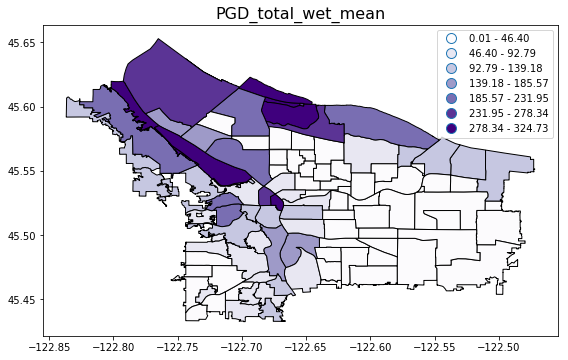

In [15]:
# Plot column value for each geometry contained in gdf
# there is a bug in geopandas plot function when column value
# is categorical and ordered!  Misorders labels and/or omits labels!
col2plot = 'PGD_total_wet_mean'
#col2plot = 'pgv_site_mean'
#help(gdf_merge_class.plot)
categorical = False
savefig = False
if categorical:
    k = None
    scheme = None
else:
    k = 7
    scheme = 'Equal_interval'
    
# Plotting
fig, ax = plt.subplots(1, figsize=(8, 8))
basemap = gdf_merge_class.plot(column=col2plot, cmap='Purples', ax=ax, k=k,
        categorical=categorical, scheme=scheme, legend=True, linewidth=1, edgecolor='k'
)
#basemap = gplt.choropleth(gdf_merge_class, hue=col2plot, projection=gplt.crs.PlateCarree(),
#        cmap='Purples', categorical=categorical, legend=True, linewidth=1, edgecolor='k',
#        legend_labels=['None', 'Low', 'Moderate', 'High', 'Very High']
#)
ax.set_aspect('equal')
ax.set_title(col2plot, fontsize=16)
plt.tight_layout()
if savefig:
    plt.savefig(col2plot+"final.png", bbox_inches='tight', pad_inches=0.1)

In [ ]:
gdf_merge_class['PGD_landslide_dry_max_DI']
#help(gdf_merge_class.plot)
#help(gplt.choropleth)

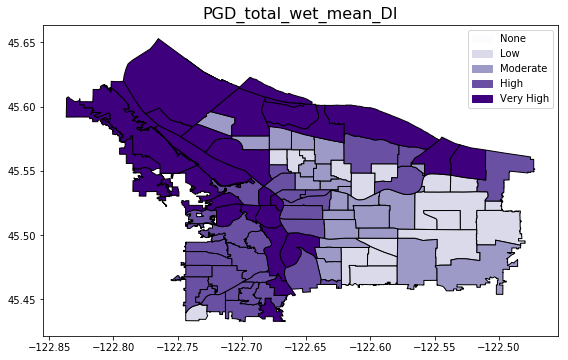

In [16]:
# Plot a single class label within a given categorical column
# This is for categorical data ONLY!
#cmap = plt.cm.Purples(0.5)
#print(cmap)
colbase = 'PGD_total_wet'
col2plot = colbase + '_mean_DI'
#colbase = 'pgv_site'
#col2plot = colbase + '_mean_MMI'
categorical = True
# Plotting
num_labels = len(params['stats_classification'][colbase]['level_labels'])
fig, ax = plt.subplots(1, figsize=(8, 8))
legend_patches = []
import matplotlib.patches as mpatches
for ind, lab in enumerate(params['stats_classification'][colbase]['level_labels']):
    #print(ind/num_labels)
    gdf_catplot = gdf_merge_class.loc[gdf_merge_class[col2plot]==lab, ['geometry', col2plot]]
    #print(gdf_catplot)
    if not gdf_catplot.empty:
        ph = gdf_catplot.plot(color=plt.cm.Purples(ind/(num_labels-1)), ax=ax,
                categorical=categorical, linewidth=1, edgecolor='k', legend=True
        )
    legend_patches.append(mpatches.Patch(color=plt.cm.Purples(ind/(num_labels-1)), label=lab))
ax.set_aspect('equal')
ax.set_title(col2plot, fontsize=16)
ax.legend(handles=legend_patches)
#plt.legend(handles=[red_patch])
#ax.legend(labels=params['stats_classification'][colbase]['level_labels'])
plt.tight_layout()
plt.savefig(col2plot+"final.png", bbox_inches='tight', pad_inches=0.1)

In [15]:
gdf_catplot = gdf_merge_class.loc[gdf_merge_class[col2plot]=="None", ['geometry', col2plot]]
print(gdf_catplot)

                                             geometry PGD_landslide_dry_max_DI
0   POLYGON ((-122.6507145389833 45.55771642087534...                     None
5   POLYGON ((-122.614981986521 45.54159342840009,...                     None
6   POLYGON ((-122.6306818771524 45.55538866746576...                     None
7   POLYGON ((-122.6785907221789 45.57721311608243...                     None
10  POLYGON ((-122.6204171746656 45.55827244803094...                     None
21  POLYGON ((-122.6205276341607 45.57178328363822...                     None
22  POLYGON ((-122.6355726096674 45.49736359937333...                     None
30  POLYGON ((-122.5787153259191 45.49741660780386...                     None
31  POLYGON ((-122.4969555859967 45.52642623818219...                     None
35  POLYGON ((-122.5299593993421 45.50406385065699...                     None
37  POLYGON ((-122.6149901393517 45.53777814201931...                     None
40  POLYGON ((-122.664753447117 45.56643405547096,..

In [16]:
gdf_catplot = gdf_merge_class.loc[gdf_merge_class[col2plot]=="Moderate", ['geometry', col2plot]]
print(not gdf_catplot.empty)

False
